In [1]:

## copying old work of mine https://github.com/btatkinson/NCAA-basketball-Capstone/blob/main/notebooks/blake_exploratory/team_network_demo_fake_data.ipynb

import gc
import os
import time
import torch
import random

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from copy import copy
from tqdm import tqdm
from faker import Faker
from itertools import combinations


## Team Network demo
The goal of this notebook is to show network concepts that can aid college basketball analysis

- I'll start in the abstract, with simulated scores.  
- Then I'll move to actual CBB data  

In [2]:

nodes = {}

G = nx.DiGraph()
G.add_nodes_from(['A','B','C','D'])
# Specify the edges you want here
red_edges = [('A','D')]
black_edges = [('A','B'),('C','D'),('B','C')]
black_edge_labels = {
    ('A','B'):'Beat',
    ('C','D'):'Beat',
    ('B','C'):'Beat'
}
red_edge_labels = {
    ('A','D'):'?'
}
G.add_edges_from(red_edges+black_edges)
edge_colors = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]


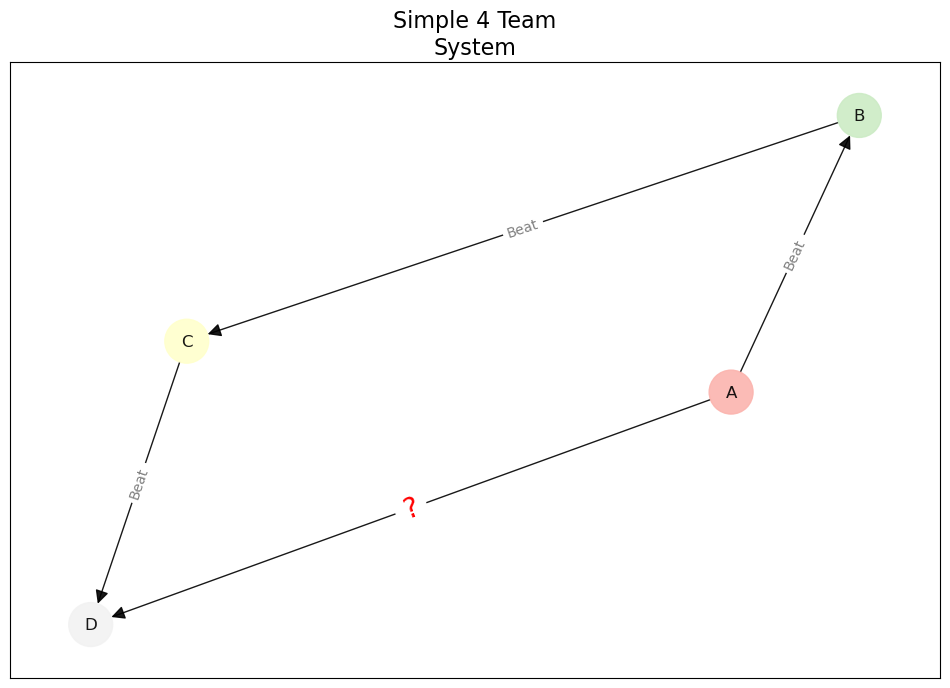

In [3]:


values = [0, 0.33, 0.66, 1]
fig, ax = plt.subplots(figsize=(12,8))
# Need to create a layout when doing
# separate calls to draw nodes and edges

pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('cool'), 
#                        node_color = values, node_size = 500)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='g', arrowsize=20, arrows=True)
nx.draw_networkx(G, pos, edge_color='black', width=1, linewidths=1, arrowsize=20, node_color=values, node_size=1000, cmap='Pastel1', alpha=0.9,labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=black_edge_labels,
    font_color='gray'
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=red_edge_labels,
    font_color='red',
    font_size=20
)
# nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrowsize=20, arrows=True)
plt.annotate("test",(0.5,0.5))
plt.title('Simple 4 Team\nSystem',fontsize=16)
plt.savefig('C://Users/Blake/Downloads/PageRank_simple.png')
plt.show()

In [4]:


# Randomly generate game results with noise centered around true skill

def play_game(skill_1, skill_2, vol=3):
    return np.random.normal(skill_1, vol) - np.random.normal(skill_2, vol)


def play_season(schedule, skill_dict_a, skill_dict_b):
    
    game_results = []
    
    for game in schedule:
        
        team_1_true_skill_a = skill_dict_a[game[0]]
        team_2_true_skill_a = skill_dict_a[game[1]]
        team_1_true_skill_b = skill_dict_b[game[0]]
        team_2_true_skill_b = skill_dict_b[game[1]]
        
        game_result_a = play_game(team_1_true_skill_a, team_2_true_skill_a)
        game_result_b = play_game(team_1_true_skill_b, team_2_true_skill_b)
        
        game_results.append([game[0], game[1], game_result_a, game_result_b])
        game_results.append([game[1], game[0], -1*game_result_a, -1*game_result_b])
    return pd.DataFrame(game_results, columns=['player_1','player_2','result_a','result_b'])




In [67]:


def calc_multiple_ratings(A, v, num_players, num_iterations=100):

        dampen = 1/(num_players)
        A = (dampen * A + (1 - dampen) / num_players) 

        for i in range(num_iterations):
            v = torch.einsum('ijk,jk->ik', A, v)
            norm = torch.linalg.norm(v, axis=0)
            v = v/norm
        return v*num_players
    
# def calc_multiple_ratings_trad(rtg_matrix, player_rtgs, num_players, num_iterations=100, d=0.99):

#     # Row-normalize the rating matrix
#     row_sums = torch.sum(rtg_matrix, axis=1, keepdim=True)
#     normalized_matrix = rtg_matrix / row_sums

#     # Apply damping factor
#     S = torch.ones_like(rtg_matrix) / num_players
#     A = d * normalized_matrix + (1 - d) * S
    
#     v = torch.clone(player_rtgs)

#     for i in range(num_iterations):
#         v = torch.einsum('ijk,jk->ik', A, v)
#         norm = torch.linalg.norm(v, axis=0)
#         v = v / norm

#     return v * num_players


In [74]:


def run_prank_sim(ratomgs):
    ## need to normalize true rating since it is relative

    fake = Faker()

    # generate teams
    players = pd.DataFrame([(fake.name(), np.random.normal(0, 1)) for i in range(18)], columns=['name', 'true_rating_a'])
    players['true_rating_b'] = [np.random.normal(0, 1) for i in range(18)]

    # need to normalize
    players['normalized_rating_a']  = (players['true_rating_a'] - players['true_rating_a'].mean())/players['true_rating_a'].std()
    players['normalized_rating_b']  = (players['true_rating_b'] - players['true_rating_b'].mean())/players['true_rating_b'].std()

    
    skill_dict_a = players.copy().set_index('name').to_dict()['normalized_rating_a']
    skill_dict_b = players.copy().set_index('name').to_dict()['normalized_rating_b']
    
    num_players = len(skill_dict_a.keys()) 
    num_stats = 2
    result_matrix = torch.zeros((num_players, num_players, num_stats))
    
    name2id = {name:i for i,name in enumerate(skill_dict_a.keys())}
    id2name = {v:k for k,v in name2id.items()}

    schedule = list(combinations(list(players.name.values),2))

    game_results = play_season(schedule, skill_dict_a, skill_dict_b)
    update = game_results.copy()
    update['winner_index_a'] = np.where(update['result_a']>0, update['player_1'].map(name2id), update['player_2'].map(name2id))
    update['loser_index_a'] = np.where(update['result_a']>0, update['player_2'].map(name2id), update['player_1'].map(name2id))
    update['winner_index_b'] = np.where(update['result_b']>0, update['player_1'].map(name2id), update['player_2'].map(name2id))
    update['loser_index_b'] = np.where(update['result_b']>0, update['player_2'].map(name2id), update['player_1'].map(name2id))
    update = update.drop_duplicates(subset=['winner_index_a','loser_index_a','winner_index_b']).reset_index(drop=True)
    
    update_torch_indices = torch.from_numpy(update[['winner_index_a','loser_index_a']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_a'].abs().astype('float32').values)
    result_matrix[update_torch_indices[:, 0], update_torch_indices[:, 1], 0] = update_torch_values
    
    update_torch_indices = torch.from_numpy(update[['winner_index_b','loser_index_b']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_b'].abs().astype('float32').values)
    result_matrix[update_torch_indices[:, 0], update_torch_indices[:, 1], 1] = update_torch_values

    ## with dampening, not a symmetrical result
    ## have to do reverse and average the two
    rev_result_matrix = torch.zeros((num_players, num_players, num_stats))
    update_torch_indices = torch.from_numpy(update[['winner_index_a','loser_index_a']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_a'].abs().astype('float32').values)
    rev_result_matrix[update_torch_indices[:, 1], update_torch_indices[:, 0], 0] = update_torch_values

    update_torch_indices = torch.from_numpy(update[['winner_index_b','loser_index_b']].astype(int).values)
    update_torch_values = torch.from_numpy(update['result_b'].abs().astype('float32').values)
    rev_result_matrix[update_torch_indices[:, 1], update_torch_indices[:, 0], 1] = update_torch_values
    
    rec_ratings = calc_multiple_ratings(result_matrix, torch.rand((num_players, 2)), num_players)
    rev_rec_ratings = calc_multiple_ratings(rev_result_matrix, torch.rand((num_players, 2)), num_players)

    players = [id2name[i] for i in range(num_players)]
    df_eval = pd.DataFrame({
        'name':players,
        'true_a':[skill_dict_a[p] for p in players],
        'true_b':[skill_dict_b[p] for p in players],
        'recovered_a':[float(n) for n in list(rec_ratings[:,0])],
        'recovered_b':[float(n) for n in list(rec_ratings[:,1])],
        'rev_recovered_a':[float(n) for n in list(rev_rec_ratings[:,0])],
        'rev_recovered_b':[float(n) for n in list(rev_rec_ratings[:,1])]
    })

    df_eval['normalized_recovered_a']  = (df_eval['recovered_a'] - df_eval['recovered_a'].mean())/df_eval['recovered_a'].std()
    df_eval['normalized_recovered_b']  = (df_eval['recovered_b'] - df_eval['recovered_b'].mean())/df_eval['recovered_b'].std()
    df_eval['normalized_rev_recovered_a']  = (df_eval['rev_recovered_a'] - df_eval['rev_recovered_a'].mean())/df_eval['rev_recovered_a'].std()
    df_eval['normalized_rev_recovered_b']  = (df_eval['rev_recovered_b'] - df_eval['rev_recovered_b'].mean())/df_eval['rev_recovered_b'].std()

    df_eval['pagerank_norm_a'] = (df_eval['normalized_recovered_a'].copy()+-1*df_eval['normalized_rev_recovered_a'].copy())/2
    df_eval['pagerank_norm_b'] = (df_eval['normalized_recovered_b'].copy()+-1*df_eval['normalized_rev_recovered_b'].copy())/2

    df_eval = df_eval.drop(columns=['recovered_a','recovered_b','rev_recovered_a','rev_recovered_b','normalized_recovered_a',
                                   'normalized_rev_recovered_a','normalized_recovered_b','normalized_rev_recovered_b'])

    return update, df_eval


class EloRating():
    def __init__(self, mu=1500):
        self.mu = mu
        self.games_played = 0


        
def play_single_match(p1, p2, result, k=24):
    exp = 1/(1+10**((p2.mu-p1.mu)/400))
    mod = k*(result-exp)
    return mod


def add_elo_sim(res, eval_data):
    
    res['winner_a'] = np.where(res['result_a']>0, 1, 0)
    res['winner_b'] = np.where(res['result_b']>0, 1, 0)
    
    
    elo_rtgs_a = {}
    elo_rtgs_b = {}
    for name in set(res['player_1']).union(set(res['player_2'].unique())):
        elo_rtgs_a[name] = EloRating()
        elo_rtgs_b[name] = EloRating()
        
    res = res.sample(frac=1).reset_index(drop=True)
    
    for index, row in res.iterrows():
        p1 = row['player_1']
        p2 = row['player_2']

        p1_rtg_a = elo_rtgs_a[p1]
        p2_rtg_a = elo_rtgs_a[p2]
        mod_a = play_single_match(p1_rtg_a, p2_rtg_a, row['result_a'])
        p1_rtg_a.mu+=mod_a
        p2_rtg_a.mu-=mod_a
        elo_rtgs_a[p1] = copy(p1_rtg_a)
        elo_rtgs_a[p2] = copy(p2_rtg_a)

        p1_rtg_b = elo_rtgs_b[p1]
        p2_rtg_b = elo_rtgs_b[p2]
        mod_b = play_single_match(p1_rtg_b, p2_rtg_b, row['result_b'])
        p1_rtg_b.mu+=mod_b
        p2_rtg_b.mu-=mod_b

        elo_rtgs_b[p1] = copy(p1_rtg_b)
        elo_rtgs_b[p2] = copy(p2_rtg_b)


    eval_data['elo_mu_a'] = eval_data['name'].apply(lambda x: elo_rtgs_a[x].mu)
    eval_data['elo_mu_b'] = eval_data['name'].apply(lambda x: elo_rtgs_b[x].mu)
    
    eval_data['norm_elo_mu_a'] = (eval_data['elo_mu_a'] - eval_data['elo_mu_a'].mean())/eval_data['elo_mu_a'].std()
    eval_data['norm_elo_mu_b'] = (eval_data['elo_mu_b'] - eval_data['elo_mu_b'].mean())/eval_data['elo_mu_b'].std()
    
    eval_data = eval_data.drop(columns=['elo_mu_a','elo_mu_b'])

    return res, eval_data



game_results, df_eval = run_prank_sim()
game_results, df_eval = add_elo_sim(game_results.copy(), df_eval.copy())



In [69]:
import gc
### test a bunch of times
n = 500
elo_errors = []
pr_errors = []
for i in tqdm(range(n)):
    
    game_results, df_eval = run_prank_sim(calc_multiple_ratings)
    game_results, df_eval = add_elo_sim(game_results.copy(), df_eval.copy())
    df_eval['elo_error_a'] = (df_eval['true_a']-df_eval['norm_elo_mu_a'])**2
    df_eval['elo_error_b'] = (df_eval['true_b']-df_eval['norm_elo_mu_b'])**2
    df_eval['pagerank_error_a'] = (df_eval['true_a']-df_eval['pagerank_norm_a'])**2
    df_eval['pagerank_error_b'] = (df_eval['true_b']-df_eval['pagerank_norm_b'])**2
    pr_errors.extend([df_eval['pagerank_error_a'].mean(), df_eval['pagerank_error_b'].mean()])
    elo_errors.extend([df_eval['elo_error_a'].mean(), df_eval['elo_error_b'].mean()])
    del df_eval
    del game_results
    gc.collect()

## one more time for plotting's sake
game_results, df_eval = run_prank_sim()
game_results, df_eval = add_elo_sim(game_results.copy(), df_eval.copy())


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:18<00:00,  6.39it/s]


In [70]:
df_eval.corr(numeric_only=True)

,true_a,true_b,pagerank_norm_a,pagerank_norm_b,norm_elo_mu_a,norm_elo_mu_b
true_a,1.000000,0.197447,0.817411,-0.284808,0.806731,-0.215565
true_b,0.197447,1.000000,0.136156,0.506102,0.162960,0.502929
pagerank_norm_a,0.817411,0.136156,1.000000,-0.291710,0.983201,-0.228410
pagerank_norm_b,-0.284808,0.506102,-0.291710,1.000000,-0.191800,0.989402
norm_elo_mu_a,0.806731,0.162960,0.983201,-0.191800,1.000000,-0.110598
norm_elo_mu_b,-0.215565,0.502929,-0.228410,0.989402,-0.110598,1.000000


In [71]:


##Elo avg error: 0.5824308739876833
##PageRank avg error: 0.512966050845869
print(f"Elo avg error: {np.mean(elo_errors)}")
print(f"PageRank avg error: {np.mean(pr_errors)}")



Elo avg error: 0.5840007629280914
PageRank avg error: 0.5105575313103632


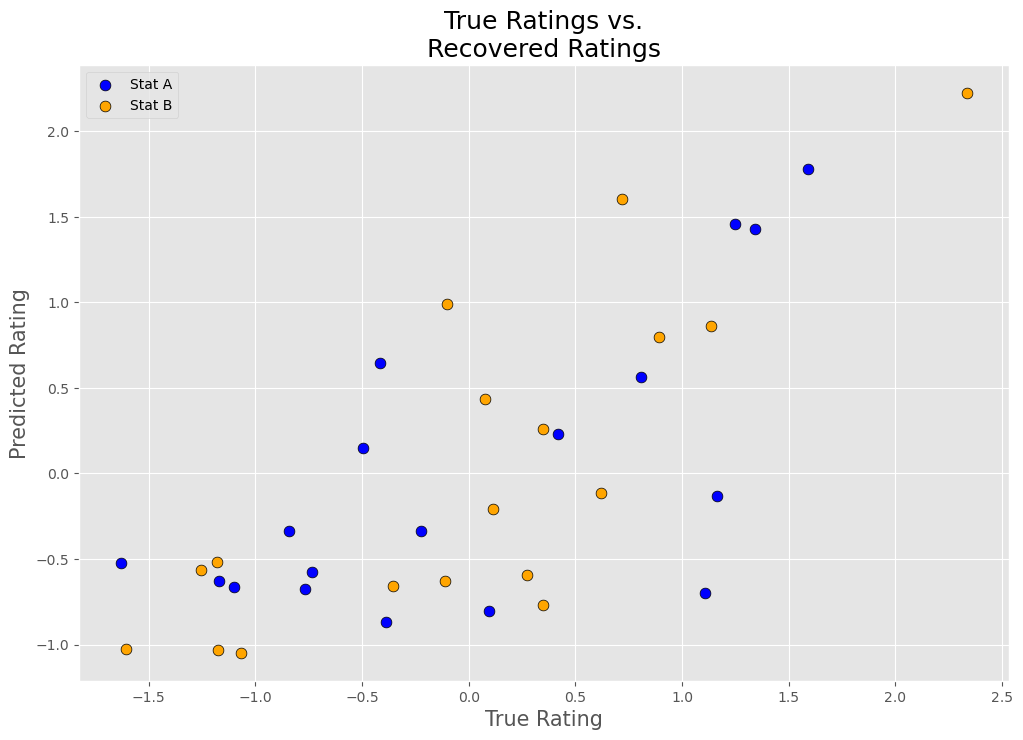

In [12]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(df_eval.true_a, df_eval.pagerank_norm_a, color='blue', label='Stat A', edgecolors='black', s=60)
ax.scatter(df_eval.true_b, df_eval.pagerank_norm_b, color='orange', label= 'Stat B', edgecolors='black', s=60)
ax.set_xlabel('True Rating',fontsize=15)
ax.set_ylabel('Predicted Rating',fontsize=15)

ax.set_title("True Ratings vs.\nRecovered Ratings",fontsize=18)
ax.legend()

plt.savefig('C://Users/Blake/Downloads/pagerank_simple.png')
plt.show()



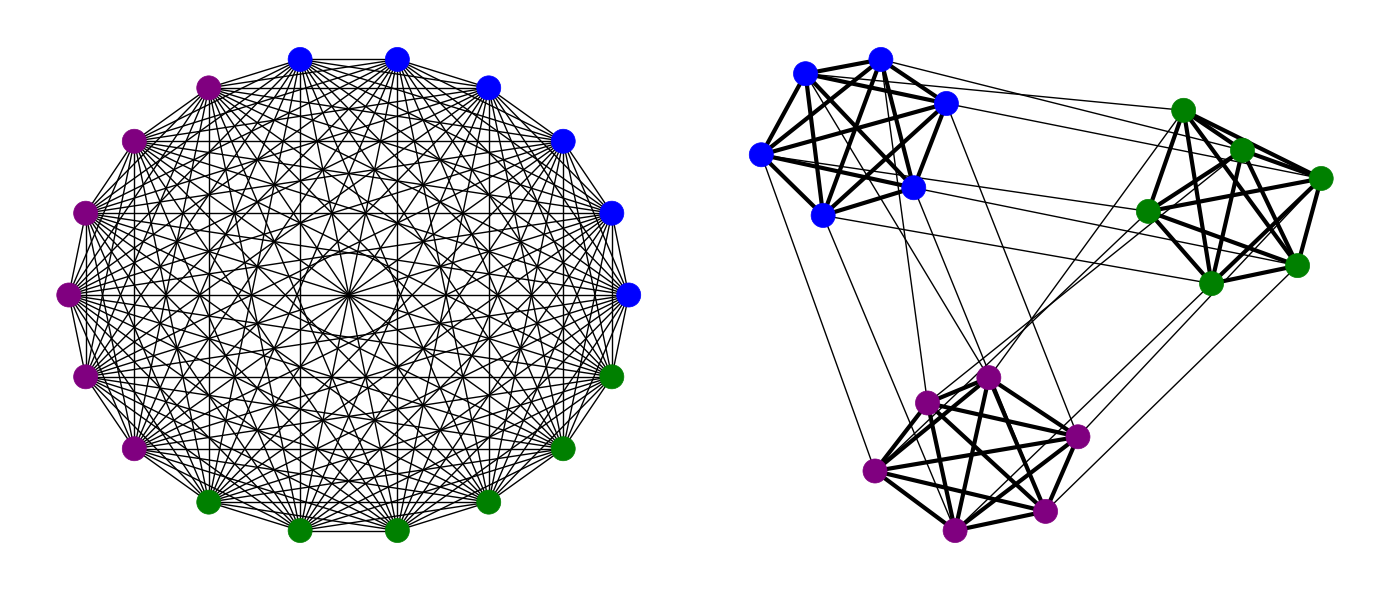

In [13]:



def get_conference_schedule(teams):
    
    """
    
    Generates conference and non-con schedule with each team playing each team in their conference 3 times
    2 non-con games, one from each other conference
    
    """
    
    team_names = list(teams.name)
    random.shuffle(team_names)
    conf_affiliation = {

    }
    conf_a_teams = []
    conf_b_teams = []
    conf_c_teams = []

    for conf_a_name in team_names[:6]:
        conf_affiliation[conf_a_name] = 'A'
        conf_a_teams.append(conf_a_name)
    for conf_b_name in team_names[6:12]:
        conf_affiliation[conf_b_name] = 'B'
        conf_b_teams.append(conf_b_name)
    for conf_c_name in team_names[12:]:
        conf_affiliation[conf_c_name] = 'C'
        conf_c_teams.append(conf_c_name)

    conf_a_schedule = list(combinations(conf_a_teams,2)) * 3
    conf_b_schedule = list(combinations(conf_b_teams,2)) * 3
    conf_c_schedule = list(combinations(conf_c_teams,2)) * 3

    full_schedule = conf_a_schedule + conf_b_schedule + conf_c_schedule

    for i in range(6):
        full_schedule.extend([(conf_a_teams[i], conf_b_teams[i]), (conf_a_teams[i], conf_c_teams[i]), (conf_c_teams[i], conf_b_teams[i])])

    assert(len(full_schedule)==153)
    teams['conf_name'] = teams['name'].map(conf_affiliation)
    
    return conf_affiliation, full_schedule

fake = Faker()

# generate teams
teams = pd.DataFrame([(fake.name(), np.random.normal(0, 1)) for i in range(18)], columns=['name', 'true_rating_a'])
conf_affiliation, conf_schedule = get_conference_schedule(teams)
# change conf_schedule to weighted graph
conf_schedule = pd.DataFrame(conf_schedule, columns=['team_1','team_2']).drop_duplicates().reset_index(drop=True)
conf_schedule['team_1_conf'] = conf_schedule['team_1'].map(conf_affiliation)
conf_schedule['team_2_conf'] = conf_schedule['team_2'].map(conf_affiliation)
conf_schedule['weight'] = np.where(conf_schedule['team_1_conf'].copy()==conf_schedule['team_2_conf'].copy(), 3, 1)

conf_schedule = list(conf_schedule[['team_1','team_2','weight']].values)
conf_schedule = [tuple(row) for row in conf_schedule]

### illustrating ###

g1 = nx.MultiGraph()
g2 = nx.Graph()

team_order = list(teams.name.values)
g1.add_nodes_from(list(team_order))
g2.add_nodes_from(list(team_order))
schedule = list(combinations(list(teams.name.values),2))
g1.add_edges_from(schedule)
g2.add_weighted_edges_from(conf_schedule)

conf_colormap = {
    'A':'blue',
    'B':'green',
    'C':'purple'
}
colormap = []
for node in g2:
    colormap.append(conf_colormap[conf_affiliation[node]])
fig, axes = plt.subplots(1, 2, figsize=(14,6))

ax1 = axes[0]
ax2 = axes[1]
# ax1.set_title('Fully Connected\nSchedule',fontsize=18)
# ax2.set_title('Conference\nSchedule',fontsize=18)
nx.draw_circular(g1, ax=ax1, node_color=['blue']*6+['purple']*6+['green']*6)
pos = nx.spring_layout(g2)
labels = nx.get_edge_attributes(g2,'weight')

weights = [g2[u][v]['weight'] for u,v in g2.edges()]
nx.draw_networkx(g2, pos, ax=ax2, node_color=colormap,width=weights,with_labels=False)
ax2.axis("off")
plt.tight_layout()
plt.savefig('C://Users/Blake/Downloads/pagerank_title.png')
# plt.savefig('C://Users/Blake/Downloads/pagerank_fully_conn.png')


In [282]:

def create_n_game_conf_schedule(conf_lists, n_games, non_con_ratio=0.1):
    
    num_non_con = max(1, int(non_con_ratio*n_games))
    num_con = n_games-num_non_con
    con_or_non_con = ['con']*num_con+['non_con']*num_non_con
#     random.shuffle(con_or_non_con)
    schedule = []
    a_players = conf_lists['A']
    b_players = conf_lists['B']
    c_players = conf_lists['C']
    for week,week_type in enumerate(con_or_non_con):
        random.shuffle(a_players)
        
        random.shuffle(b_players)
        random.shuffle(c_players)
        if week_type == 'con':
            for i in range(3):
                schedule.append([week, a_players[i*2], a_players[i*2+1]])
                schedule.append([week, b_players[i*2], b_players[i*2+1]])
                schedule.append([week, c_players[i*2], c_players[i*2+1]])
        if week_type == 'non_con':
            remaining = []
            for i in range(6):
                if i % 3 == 0:
                    schedule.append([week, a_players[i], b_players[i]])
                    remaining.append(c_players[i])
                elif i % 3 == 1:
                    schedule.append([week, b_players[i], c_players[i]])
                    remaining.append(a_players[i])
                elif i % 3 == 2:
                    schedule.append([week, a_players[i], c_players[i]])
                    remaining.append(b_players[i])
            for i in range(len(remaining)//2):
                schedule.append([week, remaining[i*2], remaining[i*2+1]])
    return pd.DataFrame(schedule, columns=['week','player_1','player_2'])

def get_pagerank_ratings(conf_schedule, id2name, skill_dict_a, skill_dict_b):
    
    num_players = 18
    num_stats = 2
#     games_played_mat = torch.zeros((num_players, num_players, num_stats))
    rat_mat = torch.zeros((num_players, num_players, num_stats))
    rev_rat_mat = torch.zeros((num_players, num_players, num_stats))
    deg_mat = torch.zeros((num_players, num_players, num_stats))
    
    conf_schedule[['result_a','result_b']] = conf_schedule[['result_a','result_b']].astype('float32')
    quick_iterator = conf_schedule.groupby('week')
    for i, week_data in quick_iterator:

#         # add 1 to games played
#         games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 0] = games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 0] + 1
#         games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 0] = games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 0] + 1
#         games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 1] = games_played_mat[torch.from_numpy(week_data['p1_index'].values), torch.from_numpy(week_data['p2_index'].values), 1] + 1
#         games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 1] = games_played_mat[torch.from_numpy(week_data['p2_index'].values), torch.from_numpy(week_data['p1_index'].values), 1] + 1

        # update winner result and loser in rev result
        rat_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] = rat_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] + torch.from_numpy(np.abs(week_data.result_a.values))
        rat_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] = rat_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] + torch.from_numpy(np.abs(week_data.result_b.values))

        rev_rat_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] = rev_rat_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] + torch.from_numpy(np.abs(week_data.result_a.values))
        rev_rat_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] = rev_rat_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] + torch.from_numpy(np.abs(week_data.result_b.values))

        deg_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] = deg_mat[torch.from_numpy(week_data['winner_index_a'].values), torch.from_numpy(week_data['loser_index_a'].values), 0] + 1
        deg_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] = deg_mat[torch.from_numpy(week_data['winner_index_b'].values), torch.from_numpy(week_data['loser_index_b'].values), 1] + 1

        deg_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] = deg_mat[torch.from_numpy(week_data['loser_index_a'].values), torch.from_numpy(week_data['winner_index_a'].values), 0] + 1
        deg_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] = deg_mat[torch.from_numpy(week_data['loser_index_b'].values), torch.from_numpy(week_data['winner_index_b'].values), 1] + 1

    ## standardize by games played
#     rat_mat = rat_mat/(games_played_mat+1e-5)
#     rev_rat_mat = rev_rat_mat/(games_played_mat+1e-5)

#     rec_ratings = laplace_cent(rat_mat)
#     rev_rec_ratings = laplace_cent(rev_rat_mat)

    rec_ratings = calc_multiple_ratings(rat_mat, deg_mat)
    rev_rec_ratings = calc_multiple_ratings(rev_rat_mat, deg_mat)
    
#     rec_ratings = calc_multiple_ratings_trad(rat_mat, torch.rand((num_players, 2)), num_players)
#     rev_rec_ratings = calc_multiple_ratings_trad(rev_rat_mat, torch.rand((num_players, 2)), num_players)

    players = [id2name[i] for i in range(num_players)]
    df_eval = pd.DataFrame({
        'name':players,
        'true_a':[skill_dict_a[p] for p in players],
        'true_b':[skill_dict_b[p] for p in players],
        'recovered_a':[float(n) for n in list(rec_ratings[:,0])],
        'recovered_b':[float(n) for n in list(rec_ratings[:,1])],
        'rev_recovered_a':[float(n) for n in list(rev_rec_ratings[:,0])],
        'rev_recovered_b':[float(n) for n in list(rev_rec_ratings[:,1])]
    })

    df_eval['normalized_recovered_a']  = (df_eval['recovered_a'] - df_eval['recovered_a'].mean())/df_eval['recovered_a'].std()
    df_eval['normalized_recovered_b']  = (df_eval['recovered_b'] - df_eval['recovered_b'].mean())/df_eval['recovered_b'].std()
    df_eval['normalized_rev_recovered_a']  = (df_eval['rev_recovered_a'] - df_eval['rev_recovered_a'].mean())/df_eval['rev_recovered_a'].std()
    df_eval['normalized_rev_recovered_b']  = (df_eval['rev_recovered_b'] - df_eval['rev_recovered_b'].mean())/df_eval['rev_recovered_b'].std()

    df_eval['pagerank_norm_a'] = (df_eval['normalized_recovered_a'].copy()+-1*df_eval['normalized_rev_recovered_a'].copy())/2
    df_eval['pagerank_norm_b'] = (df_eval['normalized_recovered_b'].copy()+-1*df_eval['normalized_rev_recovered_b'].copy())/2

    df_eval = df_eval.drop(columns=['recovered_a','recovered_b','rev_recovered_a','rev_recovered_b','normalized_recovered_a',
                                   'normalized_rev_recovered_a','normalized_recovered_b','normalized_rev_recovered_b'])

    return df_eval

def add_elo_sim(res, eval_data):
    
    res['winner_a'] = np.where(res['result_a']>0, 1, 0)
    res['winner_b'] = np.where(res['result_b']>0, 1, 0)
    
    elo_rtgs_a = {}
    elo_rtgs_b = {}
    for name in set(res['player_1']).union(set(res['player_2'].unique())):
        elo_rtgs_a[name] = EloRating()
        elo_rtgs_b[name] = EloRating()
        
    res = res.sample(frac=1).reset_index(drop=True)
    
    for index, row in res.iterrows():
        p1 = row['player_1']
        p2 = row['player_2']

        p1_rtg_a = elo_rtgs_a[p1]
        p2_rtg_a = elo_rtgs_a[p2]
        mod_a = play_single_match(p1_rtg_a, p2_rtg_a, row['result_a'])
        p1_rtg_a.mu+=mod_a
        p2_rtg_a.mu-=mod_a
        elo_rtgs_a[p1] = copy(p1_rtg_a)
        elo_rtgs_a[p2] = copy(p2_rtg_a)

        p1_rtg_b = elo_rtgs_b[p1]
        p2_rtg_b = elo_rtgs_b[p2]
        mod_b = play_single_match(p1_rtg_b, p2_rtg_b, row['result_b'])
        p1_rtg_b.mu+=mod_b
        p2_rtg_b.mu-=mod_b

        elo_rtgs_b[p1] = copy(p1_rtg_b)
        elo_rtgs_b[p2] = copy(p2_rtg_b)


    eval_data['elo_mu_a'] = eval_data['name'].apply(lambda x: elo_rtgs_a[x].mu)
    eval_data['elo_mu_b'] = eval_data['name'].apply(lambda x: elo_rtgs_b[x].mu)
    
    eval_data['norm_elo_mu_a'] = (eval_data['elo_mu_a'] - eval_data['elo_mu_a'].mean())/eval_data['elo_mu_a'].std()
    eval_data['norm_elo_mu_b'] = (eval_data['elo_mu_b'] - eval_data['elo_mu_b'].mean())/eval_data['elo_mu_b'].std()
    
    eval_data = eval_data.drop(columns=['elo_mu_a','elo_mu_b'])

    return res, eval_data


def run_n_game_conference_sim(n_games):
    fake = Faker()

    # generate teams
    players = pd.DataFrame([(fake.name()) for i in range(18)], columns=['name'])
    players['conference']  = ['A']*6+['B']*6+['C']*6
    conf_skills = {
        'A':0.3,
        'B':0,
        'C':-0.3
    }
    players['true_rating_a'] = players['conference'].copy().apply(lambda x: np.random.normal(conf_skills[x], 1))
    players['true_rating_b'] = players['conference'].copy().apply(lambda x: np.random.normal(conf_skills[x], 1))


    # # need to normalize
    players['normalized_rating_a']  = (players['true_rating_a'] - players['true_rating_a'].mean())/players['true_rating_a'].std()
    players['normalized_rating_b']  = (players['true_rating_b'] - players['true_rating_b'].mean())/players['true_rating_b'].std()

    skill_dict_a = players.copy().set_index('name').to_dict()['normalized_rating_a']
    skill_dict_b = players.copy().set_index('name').to_dict()['normalized_rating_b']

    num_players = len(skill_dict_a.keys()) 
    num_stats = 2
    result_matrix = torch.zeros((num_players, num_players, num_stats))

    name2id = {name:i for i,name in enumerate(skill_dict_a.keys())}
    name2conf = players[['name','conference']].copy().set_index('name').to_dict()['conference']
    id2name = {v:k for k,v in name2id.items()}
    conf_lists = {
        'A':[],
        'B':[],
        'C':[]
    }
    for player in skill_dict_a.keys():
        conf_lists[name2conf[player]].append(player)
        
    try:
        assert(len(conf_lists['A'])==6), print(conf_lists) ## some weird bugs here, randomly won't populate about 0.005% of the time
        assert(len(conf_lists['B'])==6), print(conf_lists)
        assert(len(conf_lists['C'])==6), print(conf_lists) 

    except:
        ## skip iteration
        return None, None, False

    conf_schedule = create_n_game_conf_schedule(conf_lists.copy(), n_games)

    conf_schedule['p1_index'] = conf_schedule['player_1'].map(name2id)
    conf_schedule['p2_index'] = conf_schedule['player_2'].map(name2id)
    conf_schedule['p1_skill_a'] = conf_schedule['player_1'].map(skill_dict_a)
    conf_schedule['p1_skill_b'] = conf_schedule['player_1'].map(skill_dict_b)
    conf_schedule['p2_skill_a'] = conf_schedule['player_2'].map(skill_dict_a)
    conf_schedule['p2_skill_b'] = conf_schedule['player_2'].map(skill_dict_b)
    conf_schedule['result_a'] = conf_schedule[['p1_skill_a','p2_skill_a']].copy().apply(lambda x: play_game(x.p1_skill_a, x.p2_skill_a), axis=1)
    conf_schedule['result_b'] = conf_schedule[['p1_skill_b','p2_skill_b']].copy().apply(lambda x: play_game(x.p1_skill_b, x.p2_skill_b), axis=1)
    conf_schedule['win_a'] = np.where(conf_schedule['result_a']>0, 1, 0)
    conf_schedule['win_b'] = np.where(conf_schedule['result_b']>0, 1, 0)

    conf_schedule['winner_index_a'] = np.where(conf_schedule['result_a']>0, conf_schedule['player_1'].map(name2id), conf_schedule['player_2'].map(name2id))
    conf_schedule['loser_index_a'] = np.where(conf_schedule['result_a']>0, conf_schedule['player_2'].map(name2id), conf_schedule['player_1'].map(name2id))
    conf_schedule['winner_index_b'] = np.where(conf_schedule['result_b']>0, conf_schedule['player_1'].map(name2id), conf_schedule['player_2'].map(name2id))
    conf_schedule['loser_index_b'] = np.where(conf_schedule['result_b']>0, conf_schedule['player_2'].map(name2id), conf_schedule['player_1'].map(name2id))

    pr_ranks = get_pagerank_ratings(conf_schedule, id2name, skill_dict_a, skill_dict_b)
    conf_schedule, df_eval = add_elo_sim(conf_schedule.copy(), pr_ranks.copy())
    
    
    return conf_schedule, df_eval, True

def calc_multiple_ratings(A, D, num_iterations=100):
        
        ## A is the Weighted Directed Graph Adjacency Matrix
        ## D is the Degree Matrix
        
        num_players = A.shape[0]
        num_stats = A.shape[-1]
        v = torch.ones((num_players, num_stats))
        
        ## dampening is required so that a team with only wins or only losses doesn't disrupt the algorithm
        dampen = 1/(num_players)
        A = (dampen * A + (1 - dampen) / num_players) 
        D = (dampen * D + (1 - dampen) / num_players) 
        
        
        
        ## normalize A with num games played
        A_stand = A/D

        ## The gist of PageRank. Repeated multiplication until the ratings stabilize.
        for i in range(num_iterations):
            v = torch.einsum('ijk,jk->ik', A_stand, v)
            norm = torch.linalg.norm(v, axis=0)
            v = v/norm
            
        return v*num_players
    
def laplace_cent(A):
    if len(A.shape) == 3:  # If there are multiple stats
        num_teams, _, num_stats = A.shape
    else:  # If there's only one stat
        num_teams, _ = A.shape
        num_stats = 1
        A = A.unsqueeze(2)  # Add a third dimension for consistency

    # Compute the in-degree matrix (diagonal) for each stat
    in_degrees = torch.sum(A, dim=1)
    D_in = torch.stack([torch.diag(in_degrees[:, i]) for i in range(num_stats)], dim=2)

    # Compute the directed Laplacian matrix for each stat
    L = D_in - A

    # Transpose the tensor for batched eigenvalue computation
    L = L.permute(2, 0, 1)

    # Compute the largest eigenvalue of the Laplacian for each stat
    eigenvalues, _ = torch.linalg.eig(L)
    lambda_max, _ = torch.max(eigenvalues.real, dim=1)

    centralities = torch.zeros((num_teams, num_stats))

    # Compute Laplacian centrality for each team and each stat
    for i in range(num_teams):
        # Remove team 'i' from the graph for each stat
        reduced_adj = A.clone()
        reduced_adj[:, i, :] = 0

        # Compute the in-degree matrix and Laplacian for the reduced graph for each stat
        reduced_in_degrees = torch.sum(reduced_adj, dim=1)
        D_in_reduced = torch.stack([torch.diag(reduced_in_degrees[:, k]) for k in range(num_stats)], dim=2)
        L_reduced = D_in_reduced - reduced_adj

        # Transpose for batched eigenvalue computation
        L_reduced = L_reduced.permute(2, 0, 1)

        # Compute the largest eigenvalue of the reduced Laplacian for each stat
        eigenvalues_reduced, _ = torch.linalg.eig(L_reduced)
        lambda_max_reduced, _ = torch.max(eigenvalues_reduced.real, dim=1)

        # Compute the Laplacian centrality for each stat
        centralities[i, :] = (lambda_max - lambda_max_reduced) * in_degrees[i, :]

    return centralities
    

### test a bunch of times
n = 10000
elo_errors = {i:[] for i in range(2, 21)}
pr_errors = {i:[] for i in range(2, 21)}
for i in tqdm(range(n)):
    n_games = random.choice(np.arange(2,21))
    game_results, df_eval, worked = run_n_game_conference_sim(n_games)
    if not worked:
        print("weird bug, skipping iteration")
        time.sleep(0.25)
        continue
    df_eval['elo_error_a'] = (df_eval['true_a']-df_eval['norm_elo_mu_a'])**2
    df_eval['elo_error_b'] = (df_eval['true_b']-df_eval['norm_elo_mu_b'])**2
    df_eval['pagerank_error_a'] = (df_eval['true_a']-df_eval['pagerank_norm_a'])**2
    df_eval['pagerank_error_b'] = (df_eval['true_b']-df_eval['pagerank_norm_b'])**2
    
    pr_error_list = pr_errors[n_games]
    elo_error_list = elo_errors[n_games]
    pr_error_list.extend([df_eval['pagerank_error_a'].mean(), df_eval['pagerank_error_b'].mean()])
    elo_error_list.extend([df_eval['elo_error_a'].mean(), df_eval['elo_error_b'].mean()])
    pr_errors[n_games] = copy(pr_error_list)
    elo_errors[n_games] = copy(elo_error_list)
    
    del df_eval
    del game_results
    gc.collect()


  1%|▉                                                                             | 122/10000 [00:22<30:43,  5.36it/s]

{'A': ['Jerome Foster', 'Randy Love', 'Joseph Campbell', 'Lauren Salazar', 'Tyrone Sellers'], 'B': ['Ralph Miller', 'Kelsey Baker', 'Diana Wilkinson', 'Erica Price', 'Brenda Roberts', 'Eduardo Buckley'], 'C': ['Jennifer Harris', 'Joseph Rodriguez', 'Laura Miller', 'Natalie Cabrera', 'Victor Hamilton', 'Julia Irwin']}
weird bug, skipping iteration


 11%|████████▍                                                                    | 1101/10000 [03:20<27:07,  5.47it/s]

{'A': ['Keith Clark', 'Dale Smith', 'Alexandra Watkins', 'David Rogers', 'Stephanie Gonzalez'], 'B': ['Timothy Jones', 'Jessica Webster', 'Michelle Barry', 'Anthony Smith', 'Elizabeth Green', 'Kevin Wallace'], 'C': ['Amanda Thompson', 'Andrea Richard', 'Benjamin Davis', 'Jesse Hensley', 'Isabel Murphy', 'Michael Taylor']}
weird bug, skipping iteration


 18%|█████████████▊                                                               | 1797/10000 [05:24<24:46,  5.52it/s]

{'A': ['James Baker', 'Robin Perez MD', 'Richard Campbell', 'Sarah Cervantes', 'Susan Stevenson', 'Janet Booker'], 'B': ['Melinda Hill', 'Ryan Lee', 'Wendy Wallace', 'Crystal Robinson', 'Lisa Stevenson'], 'C': ['Brandon Jackson', 'Lynn Zimmerman', 'Christian Brown', 'Paul Walker', 'Mr. Joseph Garcia Jr.', 'Joshua Anthony']}
weird bug, skipping iteration


 18%|██████████████▏                                                              | 1845/10000 [05:33<24:17,  5.59it/s]

{'A': ['Kristopher Noble', 'Tony Barnes', 'Kathleen Sanders', 'Marco Blair', 'Tracy Smith'], 'B': ['Amy Miller', 'Joseph Wood', 'Lisa Johnston', 'Stacey Miller', 'Marcus Brown', 'Ashley Jones'], 'C': ['Amy Mcdowell', 'Brandy Mejia', 'Robert Mitchell', 'James Barnett', 'William Spencer DDS', 'Elizabeth Perez']}
weird bug, skipping iteration


 20%|███████████████▎                                                             | 1996/10000 [06:00<24:07,  5.53it/s]

{'A': ['Jonathan Freeman', 'Jacob Moore', 'Amanda Sharp', 'Brian Williams', 'Victoria Wells', 'Jeffery Jacobs'], 'B': ['Michelle Richardson', 'Phillip Morales', 'Stephanie Navarro', 'Paige Cole', 'Rachel Carey'], 'C': ['Shawn Williams', 'David Carson', 'Jessica Allen', 'Teresa Burns', 'Amy Todd', 'Katherine Dunn']}
weird bug, skipping iteration


 22%|█████████████████▏                                                           | 2229/10000 [06:42<23:25,  5.53it/s]

{'A': ['Dylan Nelson', 'Krystal Proctor', 'Jeremiah Perez', 'Patricia Durham', 'Zachary Ayala', 'Drew Dawson'], 'B': ['Tiffany Ray', 'Donna Hicks', 'Miguel Davis', 'Susan Sanchez', 'Cody Castillo'], 'C': ['Kevin Smith', 'Jacqueline Larsen', 'Jim Mason', 'Angela Lopez', 'William Taylor', 'Jessica Wagner']}
weird bug, skipping iteration


 25%|███████████████████▏                                                         | 2485/10000 [07:28<23:05,  5.43it/s]

{'A': ['Heather Sharp DDS', 'Douglas Carter', 'Julian Flores', 'Kimberly Curry', 'Joan Hernandez', 'Jesse Keller'], 'B': ['Erica Bennett MD', 'Colleen Moore', 'Nicholas Stevens', 'Eric Hatfield', 'Stacy Foley', 'Kaylee Porter'], 'C': ['Kristen Sullivan', 'William Flores', 'James Perez', 'Henry Barker', 'Sarah Rodriguez']}
weird bug, skipping iteration


 38%|█████████████████████████████▏                                               | 3787/10000 [11:22<18:59,  5.45it/s]

{'A': ['Kathryn Martinez', 'Clayton Wilkinson', 'Carl Clark', 'George Rodriguez', 'Shelly Smith'], 'B': ['Suzanne Bennett', 'Rita Leon', 'Tara Wheeler', 'Janet Thomas', 'Nathan Proctor', 'Tiffany Palmer'], 'C': ['Christopher Jackson', 'Jordan Bell', 'Jessica Underwood', 'Kristen Cuevas', 'Rachel Fox', 'Kelly Hall']}
weird bug, skipping iteration


 41%|███████████████████████████████▎                                             | 4071/10000 [12:14<18:17,  5.40it/s]

{'A': ['David Richard', 'Roger Garcia', 'Michael Vasquez', 'James Brown', 'Robert Blair'], 'B': ['Gabriela Adams', 'Bridget Clements', 'Jeremy Jackson', 'Matthew Montgomery', 'Summer Christensen', 'Janet Massey'], 'C': ['Zachary Wright', 'Jason Horn', 'Elizabeth Parsons', 'Benjamin Cruz', 'Leslie Miller', 'Dawn Martin']}
weird bug, skipping iteration


 47%|████████████████████████████████████▍                                        | 4730/10000 [14:13<16:06,  5.45it/s]

{'A': ['Olivia Dixon', 'Maureen Moses', 'Elizabeth Clark', 'Christopher Williams', 'Michael Pierce'], 'B': ['Maria Brown', 'Allison Perkins', 'Scott Jenkins', 'Mark David', 'Amy Walker', 'James Brown'], 'C': ['Jesus Murphy', 'Amber Lewis', 'Mike Coleman', 'Melissa Wright', 'Aaron Castillo', 'Melissa Hardy']}
weird bug, skipping iteration


 49%|█████████████████████████████████████▉                                       | 4934/10000 [14:50<15:18,  5.51it/s]

{'A': ['Andrew Boyer', 'Brian Bryant', 'Mark Schmidt', 'Nicole Ashley', 'James Crawford'], 'B': ['Becky West', 'Andrew Johnson', 'Michael Schultz', 'Katherine Anderson', 'Janet Brooks', 'Katelyn Jones'], 'C': ['John Anderson', 'Benjamin Camacho', 'Luis Lee', 'Robin Hanson', 'Andrea Hall', 'Dennis Clark']}
weird bug, skipping iteration


 51%|███████████████████████████████████████                                      | 5076/10000 [15:16<14:57,  5.49it/s]

{'A': ['David Friedman', 'Andre Hughes', 'Angelica Kelly', 'Mrs. Rebecca Frost', 'Beth Anderson'], 'B': ['Amanda Williams', 'Julie Harrell', 'Eric Shaw', 'Deanna Scott', 'Brandon Carroll', 'Jeffrey Hendrix'], 'C': ['Gordon Vasquez', 'Timothy Walker', 'Steven Long', 'Nathan Stone', 'Christopher Burton', 'Donna Snyder']}
weird bug, skipping iteration


 53%|████████████████████████████████████████▍                                    | 5253/10000 [15:48<14:05,  5.62it/s]

{'A': ['Ashley Powers', 'Cristian Gordon', 'Jennifer Walker', 'Rachel Bell', 'Jeffrey Thomas'], 'B': ['Mark Rodriguez', 'Jodi Conner', 'Kevin Rodriguez', 'Bobby Green', 'Gregory Wagner', 'Ann Obrien'], 'C': ['Carrie Glenn', 'Melvin Barry', 'Michael Steele', 'Jerry Acosta', 'Gregory Coffey', 'Natasha Whitehead']}
weird bug, skipping iteration


 55%|██████████████████████████████████████████▎                                  | 5499/10000 [16:32<13:03,  5.74it/s]

{'A': ['Tara Carter', 'Erika Smith', 'Daniel Carey', 'Charles James', 'Stephen Weaver', 'Jonathan Stewart'], 'B': ['Samuel Washington', 'Debra Adams', 'Courtney Lopez', 'Willie Sanchez', 'Ryan Walters'], 'C': ['Samantha Jackson', 'Nicholas Gray', 'Stacey Peck', 'Bryan Morales', 'Jennifer Jones', 'Helen Gonzalez']}
weird bug, skipping iteration


 55%|██████████████████████████████████████████▍                                  | 5507/10000 [16:34<13:43,  5.46it/s]

{'A': ['David Mckee', 'Kenneth Rogers', 'Austin Ford Jr.', 'Christopher Jones', 'Joanna Chen'], 'B': ['Nicholas Jones', 'Pamela Brown', 'Jessica Gordon', 'Kristin Edwards', 'Jason Sandoval', 'Joshua Williams'], 'C': ['William Brown', 'Alan Schultz', 'Keith Sweeney', 'Ronald Evans', 'Eric Campbell', 'Sarah Clark DVM']}
weird bug, skipping iteration


 60%|██████████████████████████████████████████████▏                              | 6003/10000 [18:03<12:16,  5.43it/s]

{'A': ['Jacob Baker', 'Michelle Ramirez', 'Kayla Hooper', 'John Armstrong', 'Zachary Robinson'], 'B': ['Janet Smith', 'Brian Fitzgerald', 'Justin Zuniga', 'Tammy Russell', 'Zachary Stewart', 'Gary Ramos'], 'C': ['David Campbell', 'Casey Schroeder', 'Dana Bowers', 'Jennifer Thompson', 'Susan Walters', 'Daniel Thompson']}
weird bug, skipping iteration


 60%|██████████████████████████████████████████████▏                              | 6006/10000 [18:04<13:09,  5.06it/s]

{'A': ['Katrina Hughes', 'Melinda Schneider', 'Pamela Perry', 'Kimberly Perez', 'John Ramirez'], 'B': ['Alejandra Young', 'Todd Baird', 'Tiffany Williams', 'Christopher Morrow', 'Erin Phillips', 'Jennifer Brooks'], 'C': ['Julia Conrad', 'Kathleen Martinez', 'Daniel Perkins', 'Melody Cooper', 'Nathan Adams', 'David Anderson']}
weird bug, skipping iteration


 65%|█████████████████████████████████████████████████▉                           | 6479/10000 [19:30<10:33,  5.56it/s]

{'A': ['Derek Whitaker', 'Crystal Gallagher', 'Taylor Orozco', 'Heather Schneider', 'Kathy Brown', 'Daniel Smith'], 'B': ['Francis Holmes', 'Angela Castro', 'Courtney Blankenship', 'Robert Hill', 'Brittany Jackson', 'John Hall'], 'C': ['Joshua Smith', 'Christopher Hart', 'Nicholas Friedman', 'Richard Blevins', 'Alan Brandt']}
weird bug, skipping iteration


 71%|██████████████████████████████████████████████████████▋                      | 7102/10000 [21:23<08:49,  5.47it/s]

{'A': ['Jason Logan', 'Lee Duran', 'Andrea Mcmillan', 'Sean Gallagher', 'Hunter Bailey'], 'B': ['Douglas Bullock', 'Rhonda Grant', 'Pamela Barrett', 'Pamela Nguyen', 'Amber Castro', 'Angela Fischer'], 'C': ['Kenneth Williams', 'Robin Montoya', 'John Sanchez', 'Kaitlyn Travis', 'Katherine Mcdowell', 'Dr. Ashley Mathews']}
weird bug, skipping iteration


 73%|███████████████████████████████████████████████████████▉                     | 7261/10000 [21:51<08:06,  5.63it/s]

{'A': ['Logan Stanton', 'Chris Cole', 'William Hickman', 'Rachel Guerrero', 'Karen Welch', 'Christina Hinton'], 'B': ['Jose Mullen', 'Ryan Kirk', 'William Murray', 'Sharon Stone', 'Tiffany Jones', 'Xavier Jones'], 'C': ['James Russell', 'James Cox', 'Daniel Rojas', 'Stacey Hines', 'Noah Perez']}
weird bug, skipping iteration


 80%|█████████████████████████████████████████████████████████████▍               | 7974/10000 [24:00<06:06,  5.53it/s]

{'A': ['Larry Jackson', 'Sean Smith Jr.', 'Brian Buchanan', 'Vanessa Smith', 'Kathy Day', 'Brian Klein'], 'B': ['Amy Cain', 'Carol Wilson', 'Christina Richardson', 'Dr. Thomas Moore', 'Robert Aguilar'], 'C': ['Elizabeth Miller', 'Janice Haynes', 'Stefanie Sanchez', 'Steven Obrien', 'Mitchell Franklin', 'Mary Hodges DDS']}
weird bug, skipping iteration


 96%|██████████████████████████████████████████████████████████████████████████▏  | 9629/10000 [29:00<01:05,  5.69it/s]

{'A': ['Blake Chavez', 'Charles Patterson', 'Anthony Carney', 'William Stout', 'Joe Morales'], 'B': ['David Taylor', 'Kenneth Hughes', 'Melissa Smith', 'Christian Spears', 'Rebecca Roth', 'Michael Brown'], 'C': ['Miss Sheryl Dodson DDS', 'Rebecca Cox', 'Jody Holloway', 'Heather Kidd', 'Thomas Ortiz', 'Diana Wright']}
weird bug, skipping iteration


 97%|██████████████████████████████████████████████████████████████████████████▉  | 9725/10000 [29:18<00:49,  5.60it/s]

{'A': ['Charles Davidson', 'Clifford Carpenter', 'Scott Wright', 'Kelly Singh', 'Michael Macdonald', 'Timothy Winters'], 'B': ['Leslie Ashley', 'Nicole Fritz', 'Carolyn Kelly', 'Joseph Cross', 'Jeffrey Jones'], 'C': ['Christopher Walters', 'Roberto Pruitt', 'David Padilla', 'Daniel Parsons', 'Annette White', 'Colin Warren']}
weird bug, skipping iteration


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:08<00:00,  5.53it/s]


In [283]:
# df_eval.corr(numeric_only=True)

### testing other ratings functions

In [284]:
def calc_multiple_ratings_trad(rtg_matrix, player_rtgs, num_players, num_iterations=100, d=0.9999):

    # Row-normalize the rating matrix
    row_sums = torch.sum(rtg_matrix, axis=1, keepdim=True)
#     print(row_sums)
    normalized_matrix = rtg_matrix / row_sums

    # Apply damping factor
    S = torch.ones_like(rtg_matrix) / num_players
    A = d * normalized_matrix + (1 - d) * S
    
    v = torch.clone(player_rtgs)

    for i in range(num_iterations):
        v = torch.einsum('ijk,jk->ik', rtg_matrix, v)
        norm = torch.linalg.norm(v, axis=0)
        v = v / norm

    return v * num_players

calc_multiple_ratings_trad(test, torch.rand(num_players, 2), num_players)


tensor([[6.5203, 6.5203],
        [2.2832, 2.2832],
        [0.8613, 0.8613],
        [2.3481, 2.3481],
        [2.8133, 2.8133],
        [0.6540, 0.6540],
        [1.2945, 1.2945],
        [0.0000, 0.0000]])

In [285]:

# def laplace_cent(A):
#     if len(A.shape) == 3:  # If there are multiple stats
#         num_teams, _, num_stats = A.shape
#     else:  # If there's only one stat
#         num_teams, _ = A.shape
#         num_stats = 1
#         A = A.unsqueeze(2)  # Add a third dimension for consistency

#     # Compute the in-degree matrix (diagonal) for each stat
#     in_degrees = torch.sum(A, dim=0)
#     D_in = torch.stack([torch.diag(in_degrees[:, i]) for i in range(num_stats)], dim=2)

#     # Compute the directed Laplacian matrix for each stat
#     L = D_in - A

#     # Transpose the tensor for batched eigenvalue computation
#     L = L.permute(2, 0, 1)

#     # Compute the largest eigenvalue of the Laplacian for each stat
#     eigenvalues, _ = torch.linalg.eig(L)
#     lambda_max, _ = torch.max(eigenvalues.real, dim=1)

#     centralities = torch.zeros((num_teams, num_stats))

#     # Compute Laplacian centrality for each team and each stat
#     for i in range(num_teams):
#         # Remove team 'i' from the graph for each stat
#         reduced_adj = A.clone()
#         reduced_adj[:, i, :] = 0

#         # Compute the in-degree matrix and Laplacian for the reduced graph for each stat
#         reduced_in_degrees = torch.sum(reduced_adj, dim=1)
#         D_in_reduced = torch.stack([torch.diag(reduced_in_degrees[:, k]) for k in range(num_stats)], dim=2)
#         L_reduced = D_in_reduced - reduced_adj

#         # Transpose for batched eigenvalue computation
#         L_reduced = L_reduced.permute(2, 0, 1)

#         # Compute the largest eigenvalue of the reduced Laplacian for each stat
#         eigenvalues_reduced, _ = torch.linalg.eig(L_reduced)
#         lambda_max_reduced, _ = torch.max(eigenvalues_reduced.real, dim=1)

#         # Compute the Laplacian centrality for each stat
#         centralities[i, :] = (lambda_max - lambda_max_reduced) * in_degrees[i, :]

#     return centralities

# laplace_cent(test)


In [286]:

elo_error_df = pd.DataFrame([(k,np.mean(v)) for k,v in elo_errors.items()], columns=['n_games','avg_error']) 
pr_error_df = pd.DataFrame([(k,np.mean(v)) for k,v in pr_errors.items()], columns=['n_games','avg_error']) 

elo_error_df.to_csv('elo_error_10k_10pct_2_20_deg.csv', index=False)
pr_error_df.to_csv('pr_error_10k_10pct_2_20_deg.csv', index=False)


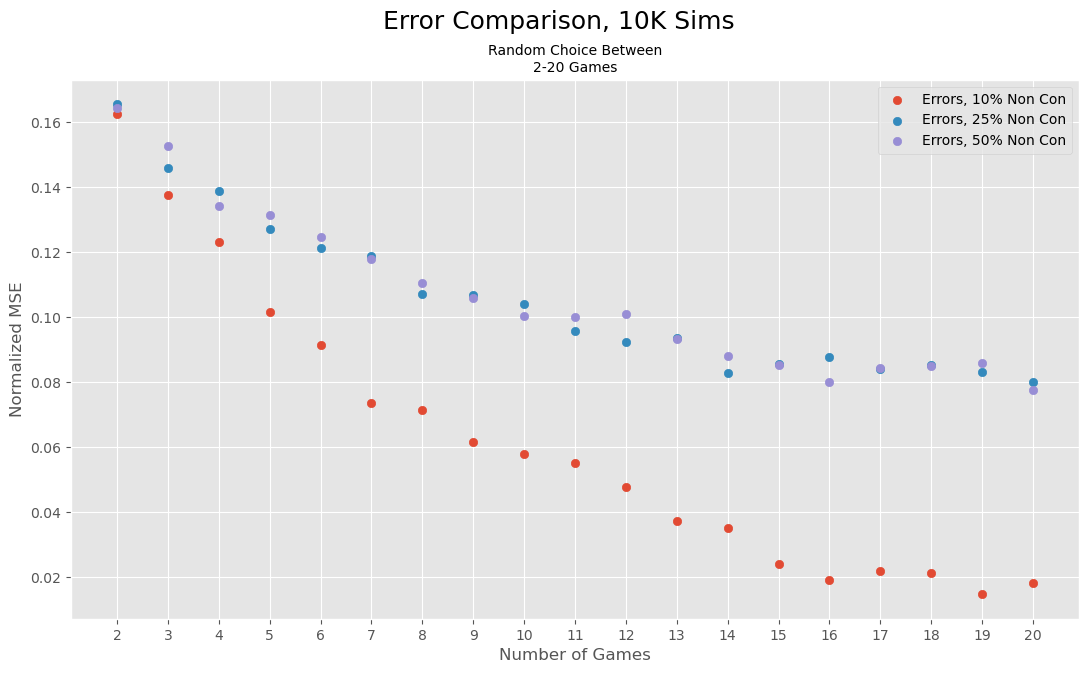

In [287]:

# elo_err_25 = pd.read_csv('elo_error_10k_25pct_2_20.csv')
# pr_err_25 = pd.read_csv('pr_error_10k_25pct_2_20.csv')

# elo_err_25 = elo_err_25.rename(columns={'avg_error':'elo_avg_error'})
# pr_err_25 = pr_err_25.rename(columns={'avg_error':'pr_avg_error'})

# err_25 = pd.merge(elo_err_25, pr_err_25, how='left', on=['n_games'])
# err_25['diff'] = err_25['elo_avg_error'].copy()-err_25['pr_avg_error'].copy()

elo_err_50 = pd.read_csv('elo_error_10k_50pct_2_20.csv')
pr_err_50 = pd.read_csv('pr_error_10k_50pct_2_20.csv')

elo_err_50 = elo_err_50.rename(columns={'avg_error':'elo_avg_error'})
pr_err_50 = pr_err_50.rename(columns={'avg_error':'pr_avg_error'})

err_50 = pd.merge(elo_err_50, pr_err_50, how='left', on=['n_games'])
err_50['diff'] = err_50['elo_avg_error'].copy()-err_50['pr_avg_error'].copy()

elo_err_10_deg = pd.read_csv('elo_error_10k_10pct_2_20_deg.csv')
pr_err_10_deg = pd.read_csv('pr_error_10k_10pct_2_20_deg.csv')

elo_err_10_deg = elo_err_10_deg.rename(columns={'avg_error':'elo_avg_error'})
pr_err_10_deg = pr_err_10_deg.rename(columns={'avg_error':'pr_avg_error'})

err_10_deg = pd.merge(elo_err_10_deg, pr_err_10_deg, how='left', on=['n_games'])
err_10_deg['diff'] = err_10_deg['elo_avg_error'].copy()-err_10_deg['pr_avg_error'].copy()

elo_err_25_deg = pd.read_csv('elo_error_10k_25pct_2_20_deg.csv')
pr_err_25_deg = pd.read_csv('pr_error_10k_25pct_2_20_deg.csv')

elo_err_25_deg = elo_err_25_deg.rename(columns={'avg_error':'elo_avg_error'})
pr_err_25_deg = pr_err_25_deg.rename(columns={'avg_error':'pr_avg_error'})

err_25_deg = pd.merge(elo_err_25_deg, pr_err_25_deg, how='left', on=['n_games'])
err_25_deg['diff'] = err_25_deg['elo_avg_error'].copy()-err_25_deg['pr_avg_error'].copy()


fig, ax = plt.subplots(figsize=(13,7))
fig.suptitle('Error Comparison, 10K Sims', fontsize=18)
ax.set_title('Random Choice Between\n2-20 Games', fontsize=10)
ax.scatter(err_10_deg.n_games, err_10_deg['diff'], label='Errors, 10% Non Con')
ax.scatter(err_25_deg.n_games, err_25_deg['diff'], label='Errors, 25% Non Con')
ax.scatter(err_50.n_games, err_50['diff'], label='Errors, 50% Non Con')
ax.set_xticks(list(np.arange(2, 21)))
ax.set_xlabel('Number of Games')
ax.set_ylabel('Normalized MSE')
ax.legend()
# plt.savefig('C://Users/Blake/Downloads/elo_pr_error_comp.png')
plt.show()


In [204]:

err_25

,n_games,elo_avg_error,pr_avg_error,diff
0,2,1.340273,1.169129,0.171144
1,3,1.210697,1.057069,0.153627
2,4,1.142792,1.004628,0.138164
3,5,1.057343,0.939005,0.118338
4,6,0.999661,0.887469,0.112193
5,7,0.949007,0.844712,0.104295
6,8,0.906016,0.799149,0.106867
7,9,0.853446,0.756948,0.096498
8,10,0.822177,0.732790,0.089388
9,11,0.782736,0.700566,0.082169
